# **MLP Project- CrimeCast: Forecasting Crime Categories**

## **Project overview**: 
We aim to develop models capable of accurately predicting the crime categories based on this dataset.

## **Dataset overview**: 
### **Data files**
The dataset consists of the following files:
- *train.csv*: The training set, inclusive of the target variable 'crime_category' and relevant feature attributes.
- *test.csv*: The test set, containing similar feature attributes but excluding the target variable 'crime_category', as it is the variable to be predicted.
- *sample_submission.csv*: A sample submission file provided in the correct format for competition submissions.

### **Columns Description**:
* Location: Street address of the crime incident.
* Cross_Street: Cross street of the rounded address.
* Latitude: Latitude coordinates of the crime incident.
* Longitude: Longitude coordinates of the crime incident.
* Date_Reported: Date the incident was reported.
* Date_Occurred: Date the incident occurred.
* Time_Occurred: Time the incident occurred in 24-hour military time.
* Area_ID: LAPD's Geographic Area number.
* Area_Name: Name designation of the LAPD Geographic Area.
* Reporting_District_no: Reporting district number.
* Part 1-2: Crime classification.
* Modus_Operandi: Activities associated with the suspect.
* Victim_Age: Age of the victim.
* Victim_Sex: Gender of the victim.
* Victim_Descent: Descent code of the victim.
* Premise_Code: Premise code indicating the location of the crime.
* Premise_Description: Description of the premise code.
* Weapon_Used_Code: Weapon code indicating the type of weapon used.
* Weapon_Description: Description of the weapon code.
* Status: Status of the case.
* Status_Description: Description of the status code.
* Crime_Category: The category of the crime (Target Variable)

In [3]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/crime-cast-forecasting-crime-categories/sample.csv
/kaggle/input/crime-cast-forecasting-crime-categories/train.csv
/kaggle/input/crime-cast-forecasting-crime-categories/test.csv


In [4]:
# Importing all the required libraries
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif

### Data Loading

In [5]:
# loading the datasets
train_df = pd.read_csv("/kaggle/input/crime-cast-forecasting-crime-categories/train.csv")
test_df = pd.read_csv("/kaggle/input/crime-cast-forecasting-crime-categories/test.csv")
sample = pd.read_csv("/kaggle/input/crime-cast-forecasting-crime-categories/sample.csv")

# checking the shape of data
print('Training data shape:', train_df.shape)
print('Test data shape:', test_df.shape)
print('Sample shape data:', sample.shape)

Training data shape: (20000, 22)
Test data shape: (5000, 21)
Sample shape data: (1000, 3)


### Exploratory data analysis (EDA)

In [6]:
# checking sample of training data
train_df.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
0,4500 CARPENTER AV,NaN,34.1522,-118.3910,03/09/2020 12:00:00 AM,03/06/2020 12:00:00 AM,1800.0,15.0,N Hollywood,1563.0,...,75.0,M,W,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
1,45TH ST,ALAMEDA ST,34.0028,-118.2391,02/27/2020 12:00:00 AM,02/27/2020 12:00:00 AM,1345.0,13.0,Newton,1367.0,...,41.0,M,H,216.0,SWAP MEET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes
2,600 E MARTIN LUTHER KING JR BL,NaN,34.0111,-118.2653,08/21/2020 12:00:00 AM,08/21/2020 12:00:00 AM,605.0,13.0,Newton,1343.0,...,67.0,M,B,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,Property Crimes
3,14900 ORO GRANDE ST,NaN,34.2953,-118.4590,11/08/2020 12:00:00 AM,11/06/2020 12:00:00 AM,1800.0,19.0,Mission,1924.0,...,61.0,M,H,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
4,7100 S VERMONT AV,NaN,33.9787,-118.2918,02/25/2020 12:00:00 AM,02/25/2020 12:00:00 AM,1130.0,12.0,77th Street,1245.0,...,0.0,X,X,401.0,MINI-MART,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes


In [7]:
# checking sample of testing data
test_df.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Modus_Operandi,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description
0,1500 LEIGHTON AV,NaN,34.0128,-118.3045,03/03/2020 12:00:00 AM,03/03/2020 12:00:00 AM,2000.0,3.0,Southwest,376.0,...,0416 1241 1243 1813 1821 2000,28.0,F,H,501.0,SINGLE FAMILY DWELLING,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont
1,100 S NORMANDIE AV,NaN,34.0726,-118.3029,06/01/2020 12:00:00 AM,04/25/2020 12:00:00 AM,1700.0,20.0,Olympic,2014.0,...,0344 0394,26.0,M,B,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,NaN,IC,Invest Cont
2,300 E 111TH ST,NaN,33.9348,-118.2695,08/28/2020 12:00:00 AM,08/27/2020 12:00:00 AM,900.0,18.0,Southeast,1844.0,...,1822 0701 1914 0355 1202 0100,62.0,F,B,721.0,HIGH SCHOOL,NaN,NaN,IC,Invest Cont
3,1300 S LA BREA AV,NaN,34.0497,-118.3442,12/23/2020 12:00:00 AM,12/03/2020 12:00:00 AM,2200.0,7.0,Wilshire,765.0,...,NaN,0.0,NaN,NaN,108.0,PARKING LOT,NaN,NaN,IC,Invest Cont
4,11000 MORRISON ST,NaN,34.1611,-118.3704,08/30/2020 12:00:00 AM,08/29/2020 12:00:00 AM,130.0,15.0,N Hollywood,1555.0,...,1501,37.0,F,W,501.0,SINGLE FAMILY DWELLING,NaN,NaN,AO,Adult Other


In [8]:
# checking information about training dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               20000 non-null  object 
 1   Cross_Street           3448 non-null   object 
 2   Latitude               20000 non-null  float64
 3   Longitude              20000 non-null  float64
 4   Date_Reported          20000 non-null  object 
 5   Date_Occurred          20000 non-null  object 
 6   Time_Occurred          20000 non-null  float64
 7   Area_ID                20000 non-null  float64
 8   Area_Name              20000 non-null  object 
 9   Reporting_District_no  20000 non-null  float64
 10  Part 1-2               20000 non-null  float64
 11  Modus_Operandi         17259 non-null  object 
 12  Victim_Age             20000 non-null  float64
 13  Victim_Sex             17376 non-null  object 
 14  Victim_Descent         17376 non-null  object 
 15  Pr

In [9]:
# checking information about testing dataset
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               5000 non-null   object 
 1   Cross_Street           810 non-null    object 
 2   Latitude               5000 non-null   float64
 3   Longitude              5000 non-null   float64
 4   Date_Reported          5000 non-null   object 
 5   Date_Occurred          5000 non-null   object 
 6   Time_Occurred          5000 non-null   float64
 7   Area_ID                5000 non-null   float64
 8   Area_Name              5000 non-null   object 
 9   Reporting_District_no  5000 non-null   float64
 10  Part 1-2               5000 non-null   float64
 11  Modus_Operandi         4316 non-null   object 
 12  Victim_Age             5000 non-null   float64
 13  Victim_Sex             4357 non-null   object 
 14  Victim_Descent         4357 non-null   object 
 15  Prem

In [10]:
# Descriptive statistics for the training dataset
train_df.describe()

,Latitude,Longitude,Time_Occurred,Area_ID,Reporting_District_no,Part 1-2,Victim_Age,Premise_Code,Weapon_Used_Code
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,7335.000000
mean,33.940704,-117.893072,1352.380350,10.834250,1129.599200,1.418150,30.135000,297.176950,366.405044
std,2.126810,7.377726,646.100291,6.033166,603.330519,0.493267,21.863645,212.007298,120.485687
min,0.000000,-118.663400,1.000000,1.000000,101.000000,1.000000,-2.000000,101.000000,101.000000
25%,34.009200,-118.429700,930.000000,6.000000,632.000000,1.000000,12.000000,101.000000,312.000000
50%,34.058700,-118.323000,1430.000000,11.000000,1162.000000,1.000000,31.000000,203.000000,400.000000
75%,34.165025,-118.274400,1900.000000,16.000000,1622.000000,2.000000,46.000000,501.000000,400.000000
max,34.328100,0.000000,2359.000000,21.000000,2197.000000,2.000000,99.000000,969.000000,515.000000


In [11]:
# Descriptive statistics for the testing dataset
test_df.describe()

,Latitude,Longitude,Time_Occurred,Area_ID,Reporting_District_no,Part 1-2,Victim_Age,Premise_Code,Weapon_Used_Code
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,1847.000000
mean,33.957169,-117.952663,1337.737400,10.736600,1119.879800,1.414000,30.592000,300.858800,364.014077
std,1.986742,6.890957,663.922202,6.051524,605.143645,0.492598,21.897905,212.253742,119.489932
min,0.000000,-118.650300,1.000000,1.000000,101.000000,1.000000,-2.000000,101.000000,101.000000
25%,34.010800,-118.431200,900.000000,6.000000,628.000000,1.000000,14.000000,101.000000,309.000000
50%,34.058000,-118.323200,1430.000000,11.000000,1138.000000,1.000000,31.000000,203.000000,400.000000
75%,34.162250,-118.274600,1900.000000,16.000000,1622.250000,2.000000,46.000000,501.000000,400.000000
max,34.327500,0.000000,2359.000000,21.000000,2197.000000,2.000000,99.000000,957.000000,516.000000


In [12]:
# Checking null values in the training dataset
train_df.isnull().sum()

Location                     0
Cross_Street             16552
Latitude                     0
Longitude                    0
Date_Reported                0
Date_Occurred                0
Time_Occurred                0
Area_ID                      0
Area_Name                    0
Reporting_District_no        0
Part 1-2                     0
Modus_Operandi            2741
Victim_Age                   0
Victim_Sex                2624
Victim_Descent            2624
Premise_Code                 0
Premise_Description          5
Weapon_Used_Code         12665
Weapon_Description       12665
Status                       0
Status_Description           0
Crime_Category               0
dtype: int64

### Majority of values in Cross_Street column are null. Thus, we can drop it.

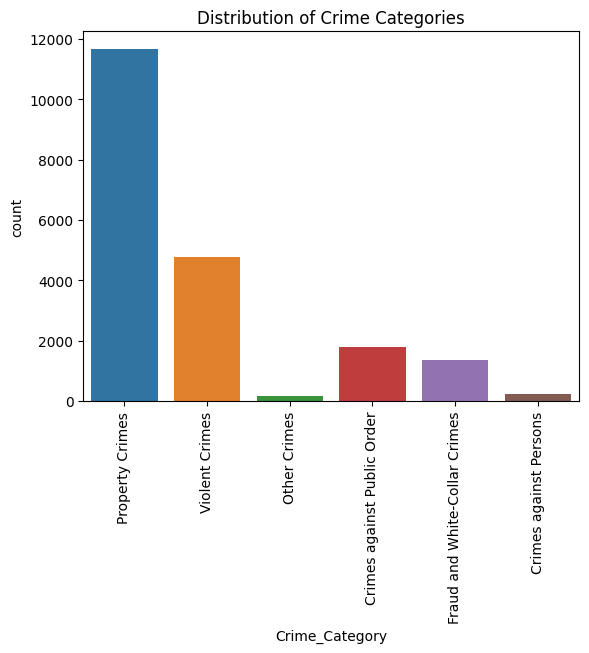

In [13]:
# Visualizing the target variable distribution using a Countplot

sns.countplot(x='Crime_Category', data=train_df)
plt.title('Distribution of Crime Categories')
plt.xticks(rotation=90)
plt.show()

### **Plot 1 Inference**: This plot visualizes the frequency distribution of crime categories which is the target variable.
1. We deduce that the majority of crimes are categorised as 'Property Crimes'.
2. This plot sheds light on the imbalance in the dataset.

In [ ]:
# Correlation heatmap for numerical features
numerical_features = train_df.select_dtypes(include=['float64', 'int64'])
corr_matrix = numerical_features.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap for Numerical Features')
plt.show()

### Plot 2 Inference: This plot visualizes correlations between the numerical features using heatmap
1. Latitude and Longitude show a perfect negative correlation value. This implies a strong inverse relation between them which is expected as they are geographical conditions.
2. Reporting_District_no and Area_ID show a strong postitive correlation. This implies they might be containg similar information.
3. Part 1-2 and Weapon_Used_Code show a moderate positive correlation (0.42). This shows that type of crime (Part 1 or Part 2) might be associated with the use of specific type of weapons. Part 1-2 also shows a slight positive correlation (0.25) with Premise_Code. 
4. Most features do not show a strong correlation with each other. This implies that there might not be strong linear relationships between most pairs of numerical features in the dataset.
5. Since mostly none of the features are highly correlated, it's unlikely that we have redundancy among the numerical features. We can include all numerical features in the model.
6. Given the weak correlations, it might be beneficial to use models that can capture non-linear relationships, such as tree-based models or bagging/boosting models.

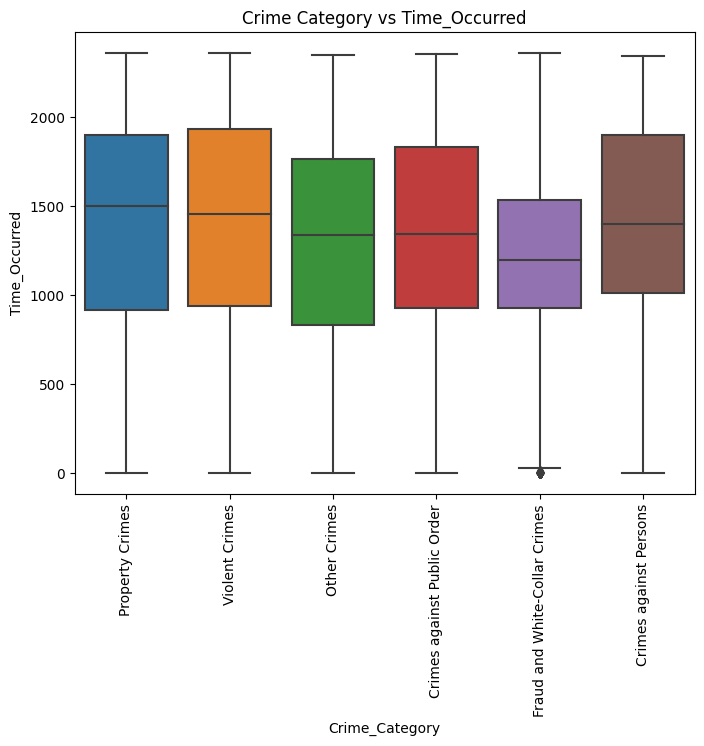

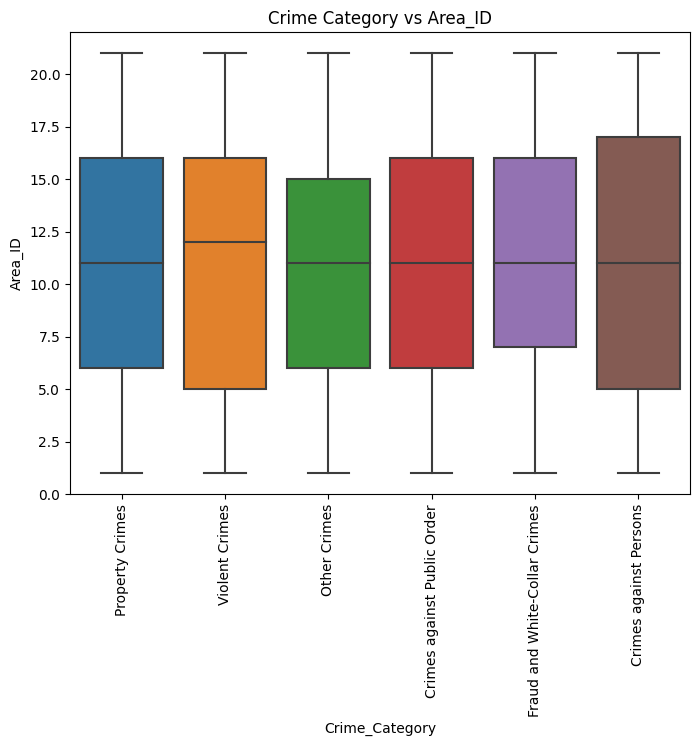

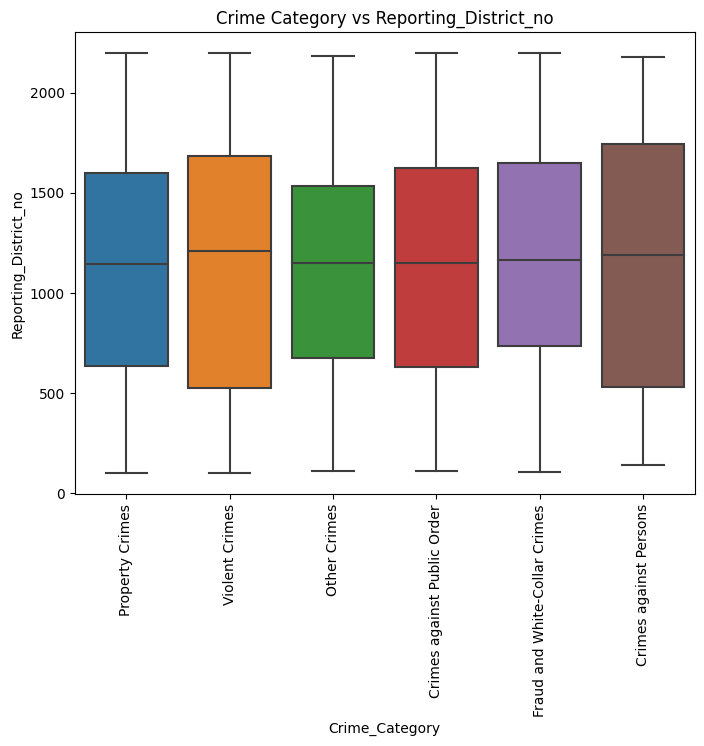

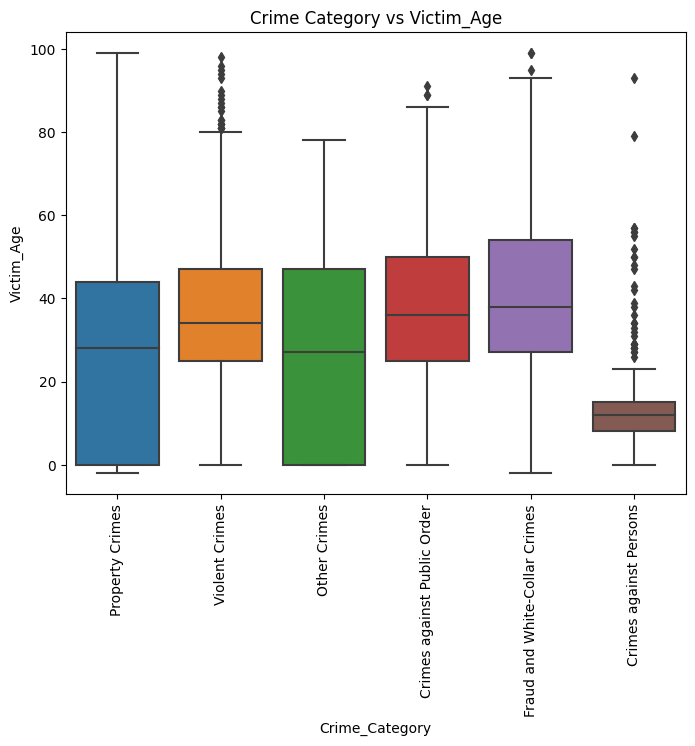

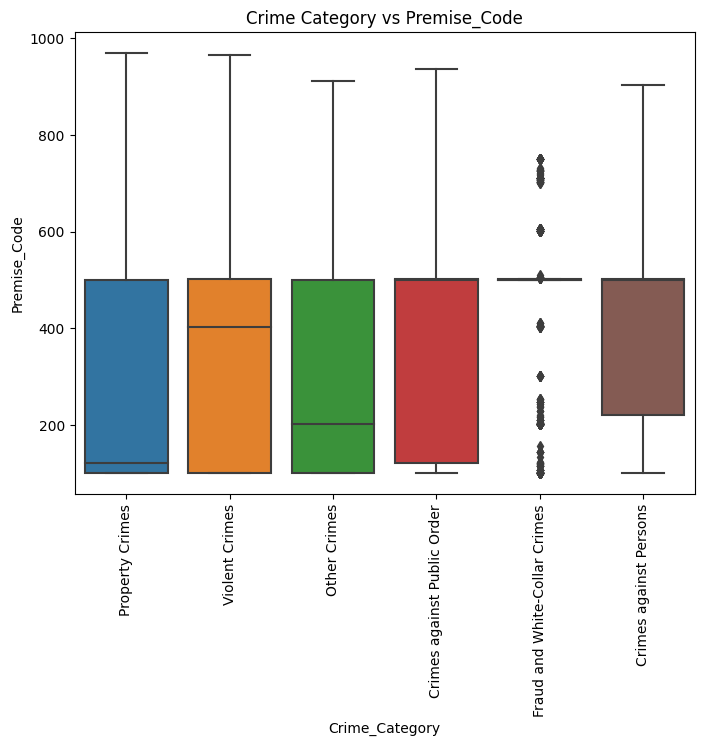

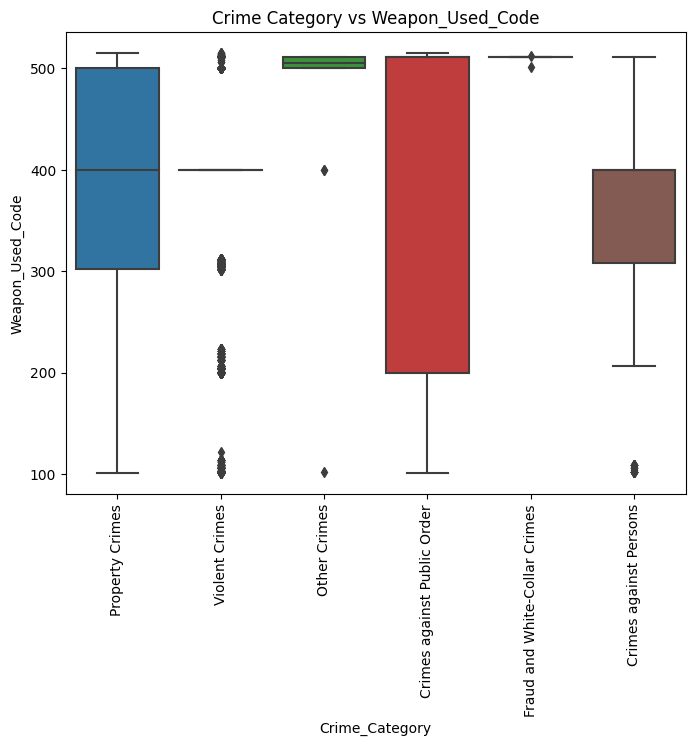

In [15]:
# Plotting box plots for all numerical features against Crime Category
numerical_features = train_df.select_dtypes(exclude=['object']).columns
numerical_features = numerical_features.drop(['Latitude', 'Longitude', 'Part 1-2'])
for col in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Crime_Category', y=col, data=train_df)
    plt.title(f'Crime Category vs {col}')
    plt.xticks(rotation=90)
    plt.show()

### Plot 3 Inference: The box plot shows the distribution of the numerical feature within each crime category.
1. These plots show prevalence of outliers among some features in the dataset.

In [16]:
# Feature engineering
# Parsing dates with specified format
date_format = "%m/%d/%Y %I:%M:%S %p"
train_df['Date_Reported'] = pd.to_datetime(train_df['Date_Reported'], format=date_format)
train_df['Date_Occurred'] = pd.to_datetime(train_df['Date_Occurred'], format=date_format)
test_df['Date_Reported'] = pd.to_datetime(test_df['Date_Reported'], format=date_format)
test_df['Date_Occurred'] = pd.to_datetime(test_df['Date_Occurred'], format=date_format)

# Extracting date features
for df in [train_df, test_df]:
    df['Day_Reported'] = df['Date_Reported'].dt.dayofweek
    df['Month_Reported'] = df['Date_Reported'].dt.month
    df['Day_Occurred'] = df['Date_Occurred'].dt.dayofweek
    df['Month_Occurred'] = df['Date_Occurred'].dt.month
    
# Drop original date columns and other columns as specified
# Area_ID and Area_Name contain simliar information 
# Status and Status_Description contain similar information
# Redundant features thus dropped
drop_columns = ['Location', 'Cross_Street', 'Date_Reported', 'Date_Occurred', 'Area_Name', 'Status_Description']
train_df = train_df.drop(columns=drop_columns)
test_df = test_df.drop(columns=drop_columns)

# Replace negative values in Victim_Age with NaN
train_df['Victim_Age'] = train_df['Victim_Age'].apply(lambda x: np.nan if x < 0 else x)
test_df['Victim_Age'] = test_df['Victim_Age'].apply(lambda x: np.nan if x < 0 else x)

# Identifying features and target variable
X = train_df.drop('Crime_Category', axis=1)
y = train_df['Crime_Category']

# Encoding the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

### Baseline model: Dummy Classifier

In [17]:
# Initialize and train the dummy classifier
# predicts the most frequent class in the training set
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

# Predict on validation set
y_val_pred = dummy_clf.predict(X_val)

# Calculate accuracy and F1 score for validation dataset
dummy_accuracy = accuracy_score(y_val, y_val_pred)
# weighted metric handles class imbalance of data
dummy_f1 = f1_score(y_val, y_val_pred, average='weighted')

print(f"Dummy Classifier Accuracy: {dummy_accuracy:.4f}")
print(f"Dummy Classifier F1 Score: {dummy_f1:.4f}")

# Save baseline metrics
baseline_metrics = {'Model': 'Dummy', 'Accuracy': dummy_accuracy, 'F1 Score': dummy_f1}

Dummy Classifier Accuracy: 0.5757
Dummy Classifier F1 Score: 0.4207


### Preprocessing data

In [18]:
# Identify categorical and numerical columns
categorical_cols = ['Part 1-2', 'Victim_Sex', 'Victim_Descent', 'Status']
ordinal_cols = ['Premise_Description', 'Weapon_Description','Day_Reported', 'Month_Reported', 'Day_Occurred', 'Month_Occurred'] 
numeric_cols = ['Latitude', 'Longitude', 'Time_Occurred', 'Victim_Age']
custom_cols = ['Modus_Operandi']
leave_cols = ['Area_ID', 'Reporting_District_no', 'Premise_Code', 'Weapon_Used_Code']

# Custom Transformer for Modus_Operandi
class ModusOperandiTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Initializes the vectorizer to convert text to binary token counts.
        self.vectorizer = CountVectorizer(tokenizer=lambda x: x.split(), binary=True)
        
    def fit(self, X, y=None):
        # Fits the vectorizer on the non-null values in the 'Modus_Operandi' column.
        self.vectorizer.fit(X.squeeze().fillna(''))
        return self
    
    def transform(self, X, y=None):
        # Transform the input data using the vectorizer
        transformed = self.vectorizer.transform(X.squeeze().fillna(''))
        #print(f"ModusOperandiTransformer input shape: {X.shape}")  # Debug statement
        #print(f"ModusOperandiTransformer output shape: {transformed.shape}")  # Debug statement
        return transformed

# Define preprocessing for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Define preprocessing for ordinal features
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Define preprocessing for custom Modus_Operandi column
modus_operandi_transformer = Pipeline(steps=[
    ('modus', ModusOperandiTransformer())
])

# Define preprocessing for leave-one-out columns
leave_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('ord', ordinal_transformer, ordinal_cols),
        ('mod', modus_operandi_transformer, custom_cols),
        ('leave', leave_transformer, leave_cols)
    ])

# Preprocess the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)
X_full_preprocessed = preprocessor.fit_transform(X)
X_test_preprocessed = preprocessor.transform(test_df)

### Model Training
##### Explanation of model choices:
- Logistic Regression: Simple and effective linear model for binary and multiclass classification.
- KNN: Non-parametric model that classifies based on the majority class among k-nearest neighbors.
- SVM: Effective in high-dimensional spaces and with various kernel functions; default RBF kernel chosen.
- Random Forest: Ensemble method that reduces overfitting by averaging multiple decision trees.
- Decision Tree: Simple and interpretable model, but prone to overfitting.
- XGBoost: Powerful gradient boosting method, often leading to better performance with default parameters.
- MLPClassifier: Flexible and effective model for multiclass classification

In [19]:
# Tests all the models
# Initiating a dictionary for the chosen models
# Default parameters for simplicity
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'XGBoost': XGBClassifier(),
    'MLPClassifier': MLPClassifier(max_iter=1000),
}

# List to store the results
results = []


for name, model in models.items():
    # Traing the model on preprocessed set
    model.fit(X_train_preprocessed, y_train)
    # making predictions on validation set
    y_val_pred = model.predict(X_val_preprocessed)
    accuracy = accuracy_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred, average='weighted')
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(f"{name} F1 Score: {f1:.4f}")
    results.append({'Model': name, 'Accuracy': accuracy, 'F1 Score': f1})

# Add baseline metrics to results
results.append(baseline_metrics)

# Convert results to DataFrame
#results_df = pd.DataFrame(results)

Logistic Regression Accuracy: 0.8732
Logistic Regression F1 Score: 0.8638
KNN Accuracy: 0.6035
KNN F1 Score: 0.5741
SVM Accuracy: 0.5870
SVM F1 Score: 0.4649
Random Forest Accuracy: 0.9437
Random Forest F1 Score: 0.9384
Decision Tree Accuracy: 0.9215
Decision Tree F1 Score: 0.9213
XGBoost Accuracy: 0.9555
XGBoost F1 Score: 0.9535
MLPClassifier Accuracy: 0.9293
MLPClassifier F1 Score: 0.9246


### Hyperparameter tuning 
#### Next, I performed hyperparameter tuning with the 4 best performing models which are:
1. Decision Tree Classifier
2. MLPClassifier
3. Random Forest Classifier
4. XGBoost Classifier

In [20]:
# Milestone 2

# Parameter grid for tuning KNN
param_grid_knn = {
    'n_neighbors': [5, 11, 15],  # Different values of k
    'weights': ['uniform', 'distance'],  # Uniform weights or distance-based weights
    'metric': ['euclidean', 'manhattan']  # Distance metric
}

# KNN model
#knn_model = KNeighborsClassifier()

# Setting up GridSearch for KNN
# grid_search_knn = GridSearchCV(estimator=knn_model, param_grid=param_grid_knn, cv=5, scoring='f1_weighted', n_jobs=-1)

# Fitting the GridSearch on training data
# grid_search_knn.fit(X_train_preprocessed, y_train)

# Getting the best estimator
# best_knn = grid_search_knn.best_estimator_

# Predicting on validation set
# y_val_pred_knn = best_knn.predict(X_val_preprocessed)

# Calculating the scores
# accuracy_knn = accuracy_score(y_val, y_val_pred_knn)
# f1_knn = f1_score(y_val, y_val_pred_knn, average='weighted')

# print(f"KNN (HPT) Accuracy: {accuracy_knn}")
# print(f"KNN (HPT) F1 Score: {f1_knn}")

# Print the best parameters found by GridSearchCV
# print(f"Best Parameters for KNN: {grid_search_knn.best_params_}")

# results.append({'Model': 'KNN (HPT)', 'Accuracy': accuracy_knn, 'F1 Score': f1_knn})

# Additionally, get the value of n_neighbors
# print(f"Best n_neighbors value for KNN: {grid_search_knn.best_params_['n_neighbors']}")

In [21]:
# Hyperparameter tuning for Decision Tree Classifier
# Parameter grid for tuning
param_grid_dt = {
    'max_depth': [None, 10], # Maximum depth of the tree.
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [10, 20, 30]
}
# Initializing model with random state for reproducibility
dt_model = DecisionTreeClassifier(random_state=42)

# Setting up GridSearch
# Five-fold CV is a standard choice to ensure a good balance between training time and reliable performance estimation.
# Weighted F1 score accounts for class imbalances by assigning different weights to different classes.
# n_jobs=-1: Utilize all available cores for parallel processing to speed up the hyperparameter search.
grid_search_dt = GridSearchCV(estimator=dt_model, param_grid=param_grid_dt, cv=5, scoring='f1_weighted', n_jobs=-1)

# fitting the model
grid_search_dt.fit(X_train_preprocessed, y_train)

# Getting the best estimator
best_dt = grid_search_dt.best_estimator_

# Predicting on validation set
y_val_pred_dt = best_dt.predict(X_val_preprocessed)

# Calculating the scores
accuracy_dt = accuracy_score(y_val, y_val_pred_dt)
f1_dt = f1_score(y_val, y_val_pred_dt, average='weighted')
print(f"Decision Tree (HPT) Accuracy: {accuracy_dt}")
print(f"Decision Tree (HPT) F1 Score: {f1_dt}")

# Print the best parameters found by GridSearchCV
print(f"Best Parameters for Decision Tree: {grid_search_dt.best_params_}")

results.append({'Model': 'Decision Tree (HPT)', 'Accuracy': accuracy_dt, 'F1 Score': f1_dt})

Decision Tree (HPT) Accuracy: 0.9205
Decision Tree (HPT) F1 Score: 0.9185510613611477
Best Parameters for Decision Tree: {'max_depth': None, 'min_samples_leaf': 20, 'min_samples_split': 2}


In [22]:
# Hyperparameter tuning for Random Forest
# Parameter grid for tuning
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [10, 20],
   # 'bootstrap': [True, False]
}
# Initializing the model with random state for reproducibility
rf_model = RandomForestClassifier(random_state=42)

# Setting up grid search and fitting the model
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search_rf.fit(X_train_preprocessed, y_train)

# getting the best estimator
best_rf = grid_search_rf.best_estimator_

# Predicting on validation set
y_val_pred_rf = best_rf.predict(X_val_preprocessed)

# Calculating scores
accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
f1_rf = f1_score(y_val, y_val_pred_rf, average='weighted')
print(f"Random Forest (HPT) Accuracy: {accuracy_rf}")
print(f"Random Forest (HPT) F1 Score: {f1_rf}")

# Print the best parameters found by GridSearchCV
print(f"Best Parameters for Random Forest: {grid_search_rf.best_params_}")

results.append({'Model': 'Random Forest (HPT)', 'Accuracy': accuracy_rf, 'F1 Score': f1_rf})

Random Forest (HPT) Accuracy: 0.914
Random Forest (HPT) F1 Score: 0.9030383751127256
Best Parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 200}


In [23]:
# Hyperparameter tuning with XGBoost model
# parameter grid for tuning
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [10,  20],
    'learning_rate': [0.01, 0.1, 0.2]
}
# Initializing model with random state for reproducibility
xgb_model = XGBClassifier(random_state=42)

# Setting up gridsearch
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, scoring='f1_weighted', n_jobs=-1)

# fitting the model on data
grid_search_xgb.fit(X_train_preprocessed, y_train)

# Getting the best estimator found by gridsearch 
best_xgb = grid_search_xgb.best_estimator_

# Predicting on validation set
y_val_pred_xgb = best_xgb.predict(X_val_preprocessed)

# Calculating accuracy and f1_scores
accuracy_xgb = accuracy_score(y_val, y_val_pred_xgb)
f1_xgb = f1_score(y_val, y_val_pred_xgb, average='weighted')
print(f"XGBoost (HPT) Accuracy: {accuracy_xgb}")
print(f"XGBoost (HPT) F1 Score: {f1_xgb}")

# Print the best parameters found by GridSearchCV
print(f"Best Parameters for XGBoost model: {grid_search_xgb.best_params_}")

results.append({'Model': 'XGBoost (HPT)', 'Accuracy': accuracy_xgb, 'F1 Score': f1_xgb})

XGBoost (HPT) Accuracy: 0.95475
XGBoost (HPT) F1 Score: 0.9530212297979866
Best Parameters for XGBoost model: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}


In [24]:
# Two-step hyperparameter tuning for XGBoost
# Step 1: Tune learning rate
param_grid_lr = {
    'learning_rate': [0.01, 0.1, 0.2]
}
grid_search_lr = GridSearchCV(estimator=xgb_model, param_grid=param_grid_lr, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search_lr.fit(X_train_preprocessed, y_train)
best_learning_rate = grid_search_lr.best_params_['learning_rate']

# Step 2: Tune other parameters using the best learning rate
param_grid_rest = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'learning_rate': [best_learning_rate]
}
grid_search_xgb_2step = GridSearchCV(estimator=xgb_model, param_grid=param_grid_rest, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search_xgb_2step.fit(X_train_preprocessed, y_train)
best_xgb_2step = grid_search_xgb_2step.best_estimator_
y_val_pred_xgb_2step = best_xgb_2step.predict(X_val_preprocessed)
accuracy_xgb_2step = accuracy_score(y_val, y_val_pred_xgb_2step)
f1_xgb_2step = f1_score(y_val, y_val_pred_xgb_2step, average='weighted')
print(f"XGBoost (2-Step HPT) Accuracy: {accuracy_xgb_2step}")
print(f"XGBoost (2-Step HPT) F1 Score: {f1_xgb_2step}")

# Print the best parameters found by GridSearchCV
print(f"Best Parameters for XGBoost 2-step model: {grid_search_xgb_2step.best_params_}")

results.append({'Model': 'XGBoost (2-Step HPT)', 'Accuracy': accuracy_xgb_2step, 'F1 Score': f1_xgb_2step})

XGBoost (2-Step HPT) Accuracy: 0.953
XGBoost (2-Step HPT) F1 Score: 0.9515270035057346
Best Parameters for XGBoost 2-step model: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 100}


### Model Comparison plots

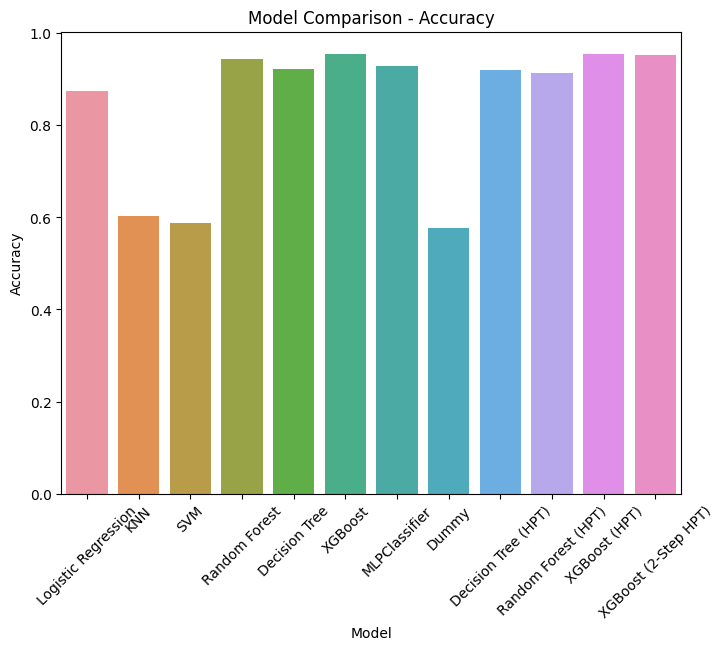

In [25]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plot the results
# Accuracy score plot
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df)
plt.title('Model Comparison - Accuracy')
plt.xticks(rotation=45)
plt.show()

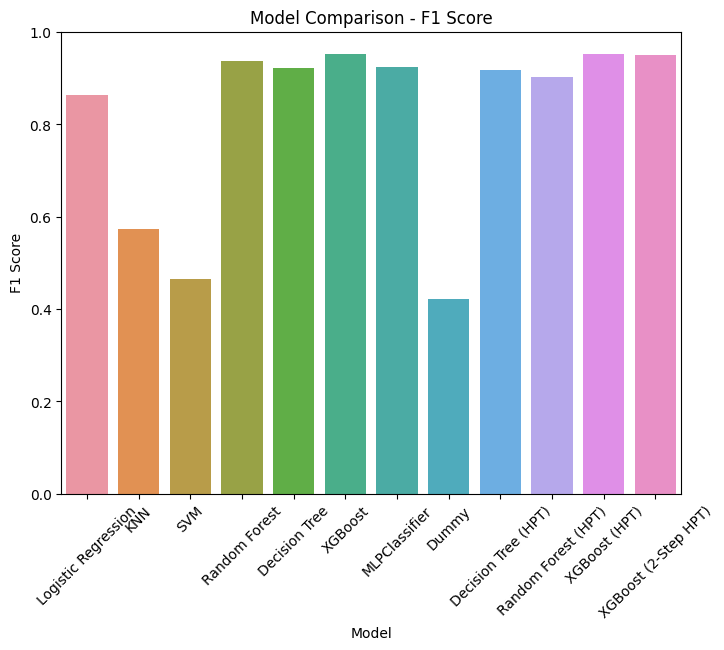

In [26]:
# F1-score plot
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='F1 Score', data=results_df)
plt.title('Model Comparison - F1 Score')
plt.xticks(rotation=45)
plt.show()


In [27]:
# Train the best model on the full dataset
best_model = XGBClassifier()  # XGBoost performed best
best_model.fit(X_full_preprocessed, y_encoded)

# Make predictions on the test set
y_test_pred = best_model.predict(X_test_preprocessed)

# Generate a new sample submission dataframe
submission = pd.DataFrame({
    'ID': range(1, len(y_test_pred) + 1),
    'Crime_Category': le.inverse_transform(y_test_pred)
})

# Save the submission file
submission.to_csv('submission.csv', index=False)